# Import data from github.

1. df_std : data of Search Trands Dataset
2. df_chcd : data of COVID Hospitalization Case Dataset


In [6]:
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

# Import data from github.
# import Search Trends dataset (simply as std)
url_std = 'https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_weekly_symptoms_dataset.csv'
df_std = pd.read_csv(url_std, index_col=0,parse_dates=[0])

# import COVID hospitalization cases dataset (simply as chcd)
url_chcd = 'https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/cc_by/aggregated_cc_by.csv'
df_chcd = pd.read_csv(url_chcd, index_col=0,parse_dates=[0])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Normalization

Normalize data of df_std (Search Trands Dataset) by method De-median




In [7]:
# reset region index
df_std.reset_index(level=0, inplace=True)

# drop first few columns that are not needed
processed = df_std.copy()
copy = df_std.copy()
processed = processed.drop(processed.iloc[:, [0,1,2,3,4,5,6,7]], axis = 1) 

# extract symptoms into a list
symptoms = copy.drop(copy.iloc[:, [0,1,2,3,4,5,6,7]], axis = 1) # drop first few columns that are not needed.
symptoms = symptoms.columns.tolist()

In [8]:
## demedian normalization

regions = df_std.open_covid_region_code.unique()

for region in regions:
  index = (df_std['open_covid_region_code'] == region)
  median = processed.loc[index].stack().median()
  # print(processed.loc[index].stack().median())
  for symptom in symptoms:
    df_std.loc[index, symptom]=df_std.loc[index, symptom]/median*10

df_std.to_csv('df_std_normalized.csv') 

Data Cleaning


1.   clean std by removing columns that contain nan values > 80% (The reason is stated in the report)
2.   Convert the date of chcd from daily to weekly
3.   Merge two dataset



In [9]:
# clean

# clean std by removing columns that contain nan values > 80% 
cleaned_std=df_std.loc[:, df_std.isnull().mean() <= .8]

#clean chcd by taking only hospitalized_new，removing the row with empty hospitalized_new
cleaned_chcd = df_chcd[['date', 'hospitalized_new']]
cleaned_chcd = cleaned_chcd.dropna(axis=0, subset=['hospitalized_new'])

# convert daily data to weekly
cleaned_chcd['date'] = cleaned_chcd ['date'].astype('datetime64[ns]')
cleaned_chcd = cleaned_chcd.groupby("open_covid_region_code").resample('W-MON', label='right', closed = 'right', on='date').sum().reset_index()

# saved to the foler on the left, click refresh and download to see the whole dataset.
cleaned_chcd.to_csv('hospitalized_new_cleaned.csv') 

In [10]:
# change date format and then merge them
cleaned_chcd["date"] = pd.to_datetime(cleaned_chcd["date"], format="%Y-%m-%d")
cleaned_std["date"] = pd.to_datetime(cleaned_std["date"], format="%Y-%m-%d")

merged = pd.merge(cleaned_chcd, cleaned_std, how='right', on=['date','open_covid_region_code'])
merged.fillna(0, inplace=True)

merged.to_csv('merged_data.csv') 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


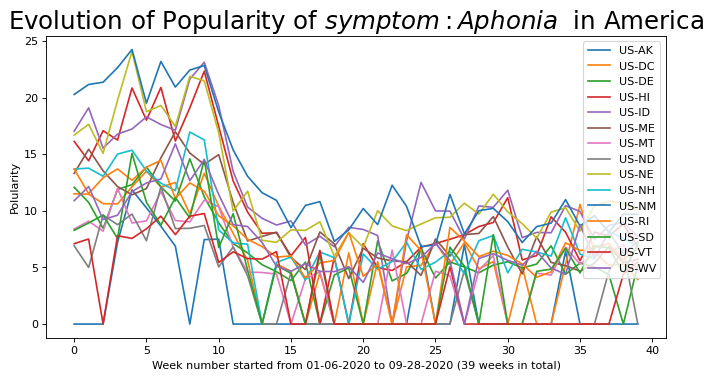

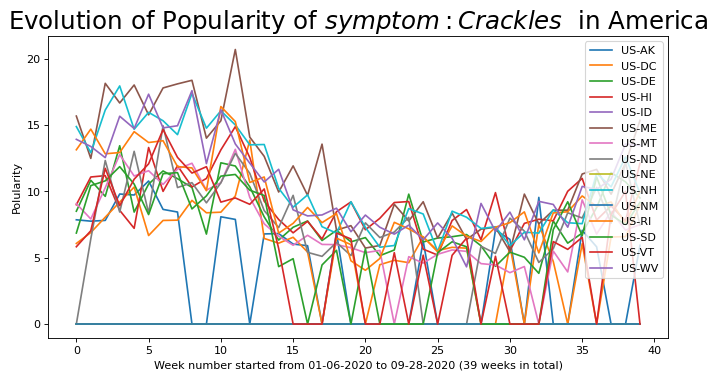

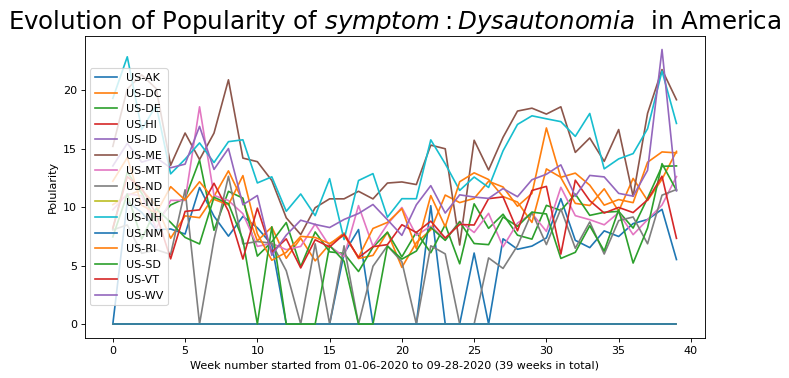

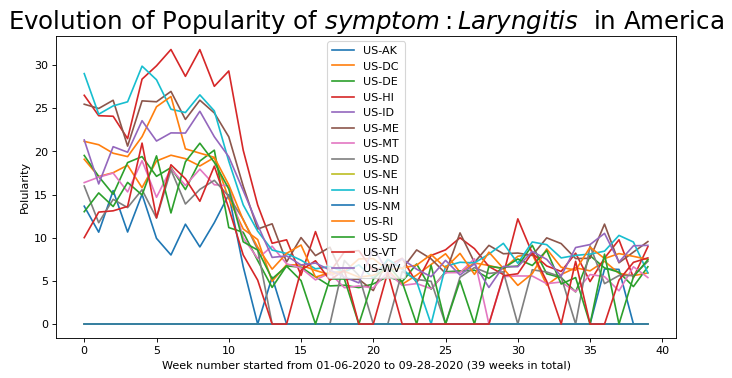

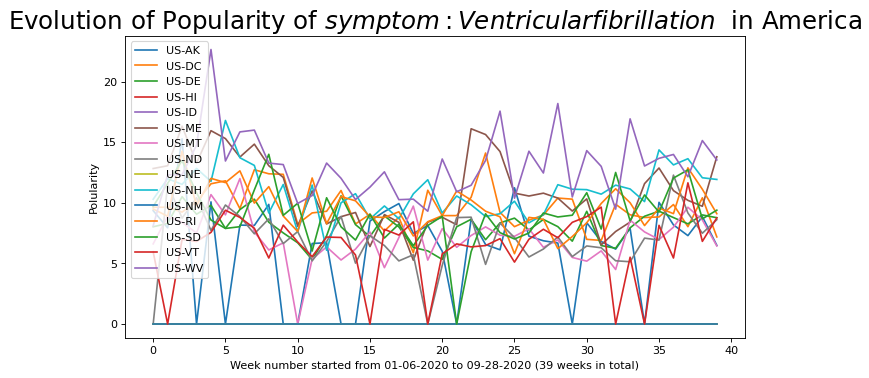

In [11]:
def symptom_popularity_plot(symptom):
  df = pd.read_csv("merged_data.csv")
  df_agg = df.loc[:, ['date', 'open_covid_region_code', symptom]].groupby('open_covid_region_code')
  vals = [df[symptom].values.tolist() for i, df in df_agg]
  plt.figure(figsize=(10,5), dpi=80)
  # plot
  for x in range(0, 15):
    plt.plot(vals[x])
  # Decoration
  colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
  plt.legend({group:col for group, col in zip(np.unique(df['open_covid_region_code']).tolist(), colors[:len(vals)])})
  plt.xlabel("Week number started from 01-06-2020 to 09-28-2020 (39 weeks in total)")
  plt.ylabel("Polularity")
  plt.title(f"Evolution of Popularity of ${symptom}$  in America", fontsize=22)
  plt.show()

symptom_popularity_plot('symptom:Aphonia')
symptom_popularity_plot('symptom:Crackles')
symptom_popularity_plot('symptom:Dysautonomia')
symptom_popularity_plot('symptom:Laryngitis')
symptom_popularity_plot('symptom:Ventricular fibrillation')

#Part II: visualization

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# extract regions and dates
regions = cleaned_std.loc[:,'open_covid_region_code']
dates = cleaned_std.loc[:,'date']

# since pca can't be applied on non-numeric datas, we either remove non-numeric columns or transform them
pca_dataset = cleaned_std.copy()

# Remove all columns between column name 'open_covid_region_code' to 'date' 
pca_dataset.drop(pca_dataset.iloc[:, 0:7], inplace = True, axis = 1) 

# fill all nan values with 0
pca_dataset.fillna(0, inplace=True)


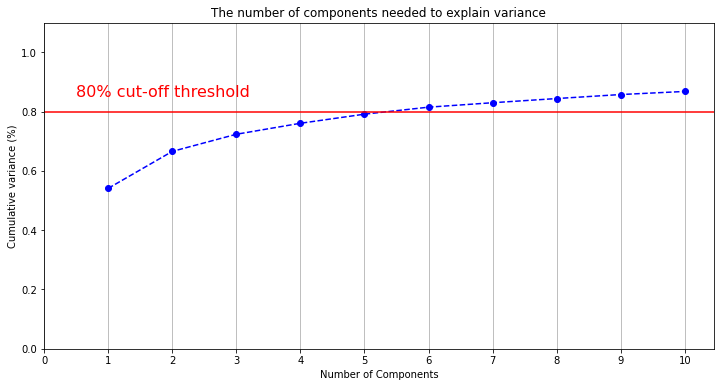

In [13]:
## standarize dataset
pca_dataset = StandardScaler().fit_transform(pca_dataset)
pca = PCA().fit(pca_dataset)

% matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 11, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
y = y[0:10]

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.80, color='r', linestyle='-')
plt.text(0.5, 0.85, '80% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [14]:
# make all features to 4 components
pca = PCA(n_components=4)

pca.fit(pca_dataset)
pca_dataset = pca.transform(pca_dataset)

matrix = pca_dataset.copy()
kmdata = pca_dataset.copy()

pca_dataset = pd.DataFrame(data=pca_dataset, columns=['1','2','3','4'])

pca_dataset.insert(0,'date',dates)
pca_dataset.insert(0,'open_covid_region_code',regions)

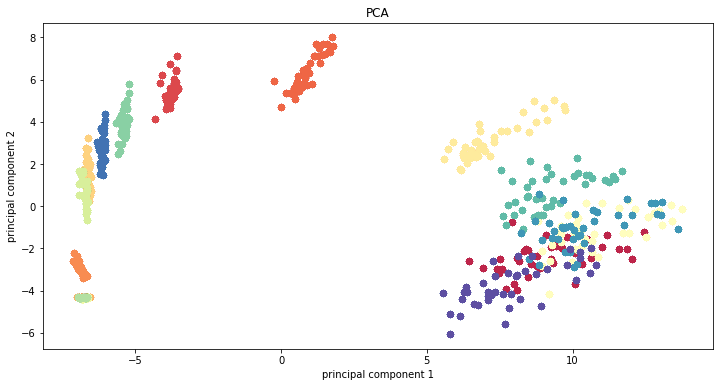

In [15]:
# assign different color to each region
length = pca_dataset.shape[0]
colors = [plt.cm.Spectral(i/float(length-1)) for i in range(length)]

# decoration
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title('PCA')
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')

for regions, color in zip(regions,colors):
  index = pca_dataset['open_covid_region_code'] == regions
  plt.scatter(pca_dataset.loc[index, '1'], pca_dataset.loc[index, '2'], color=color, linewidth=0, antialiased=False, s=50)


In [16]:
import plotly.express as px

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    matrix,
    dimensions=range(4),
    labels=labels,
    color=cleaned_std['open_covid_region_code']
)

fig.update_traces(diagonal_visible=False)
fig.show()

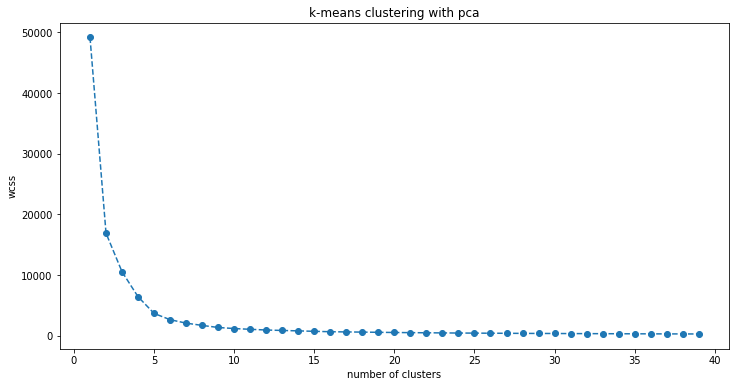

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE

wcss = []
for i in range(1,40):
  kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
  kmeans_pca.fit(kmdata)
  wcss.append(kmeans_pca.inertia_)

plt.figure()

plt.plot(range(1,40), wcss, marker='o', linestyle = '--')
plt.xlabel('number of clusters')
plt.ylabel('wcss')
plt.title('k-means clustering with pca')
plt.show()

In [18]:
kmeans_pca = KMeans(n_clusters = 8, init = 'k-means++', random_state = 42)
kmeans_pca.fit(kmdata)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

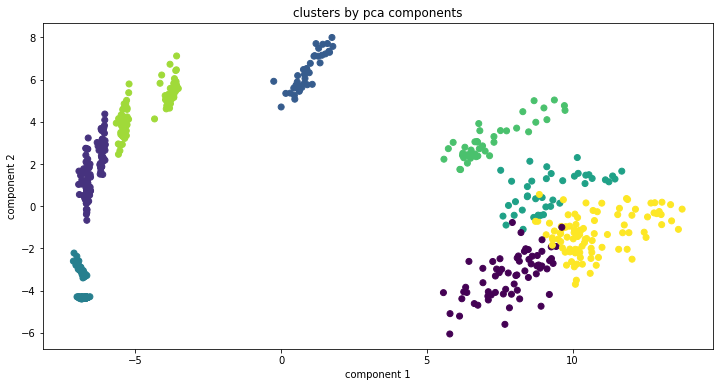

In [19]:
# plot
plt.figure()
pred = kmeans_pca.predict((kmdata))
plt.scatter(kmdata[:,0], kmdata[:,1], c=pred)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('clusters by pca components')
plt.show()

# Part III: Supervized learning 

In [20]:
def corr_calculation (data, corr): 
    get_symptom_list = data.copy();  
    get_symptom_list = get_symptom_list.drop(get_symptom_list.iloc[:, [0,1,2,3,4,5,6,7]], axis = 1) 
    symptom_list = get_symptom_list.columns.tolist()  
    num_present = 0  
    num_drop = 0  
    for symptom in symptom_list:    
        merged = data.copy()    
        # delete the row that number is 0    
        merged = merged.loc[~(merged[symptom] == 0)]   
        data1 = merged[symptom]    
        data2 = merged['hospitalized_new']    
    # 102 symptom before any drop. 48 symptom if corr > 0.3    
        if ( merged[symptom].corr(merged['hospitalized_new']) > corr):         
            num_present = num_present + 1    
        else:      
            data = data.drop(symptom, 1)      
            num_drop = num_drop + 1  
    print (num_present)  
    print (num_drop)  
    print (data.shape)  
    data.to_csv('merged_corr_data.csv') 

In [21]:
import csv
from sklearn import datasets, neighbors
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
import warnings
import random
warnings.filterwarnings('ignore')
np.random.seed(1234)

In [22]:

'''
Step #3: define MSE function
def loss(y,yh):
    np.mean((y-yh)**2)
'''
loss = lambda y, yh: np.mean((y-yh)**2)
'''    
tsting = loss(1,3)
print(tsting)
'''

'    \ntsting = loss(1,3)\nprint(tsting)\n'

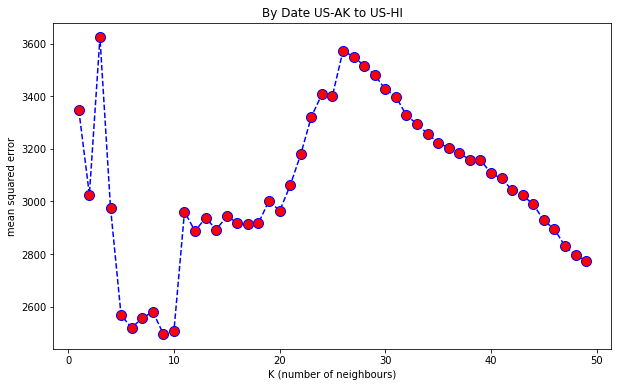

Minimum error:  2496.2678240740734 at K = 8


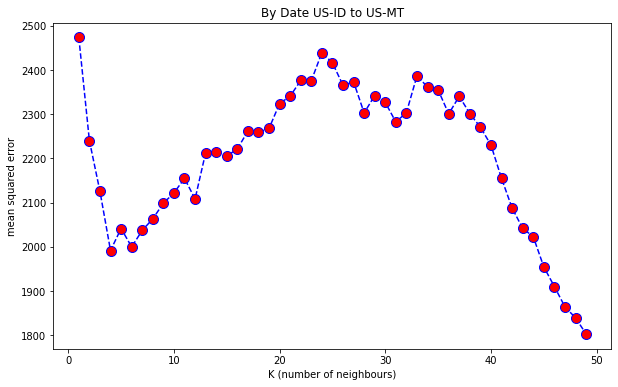

Minimum error:  1802.7365715674027 at K = 48


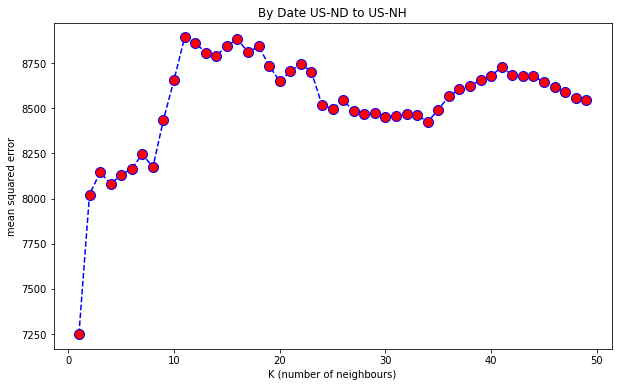

Minimum error:  7250.591666666666 at K = 0


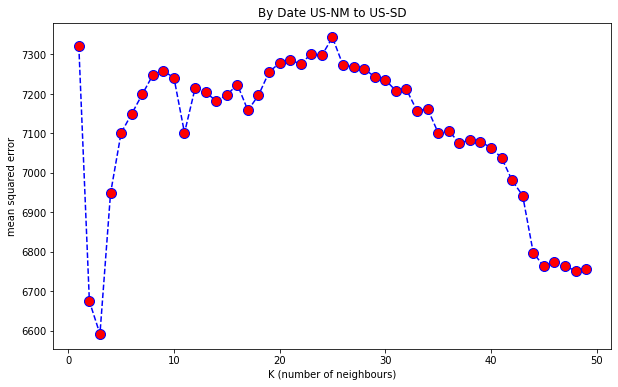

Minimum error:  6591.90092592593 at K = 2


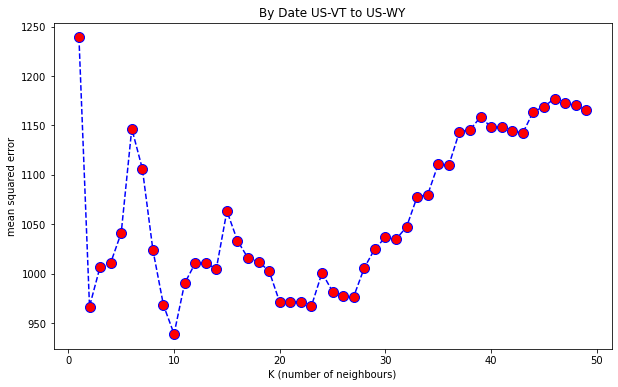

Minimum error:  938.8581666666665 at K = 9


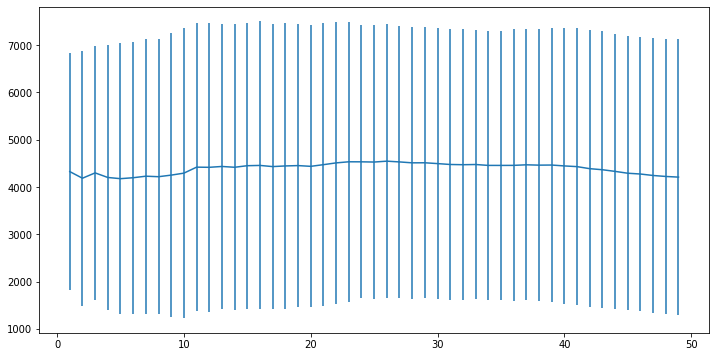

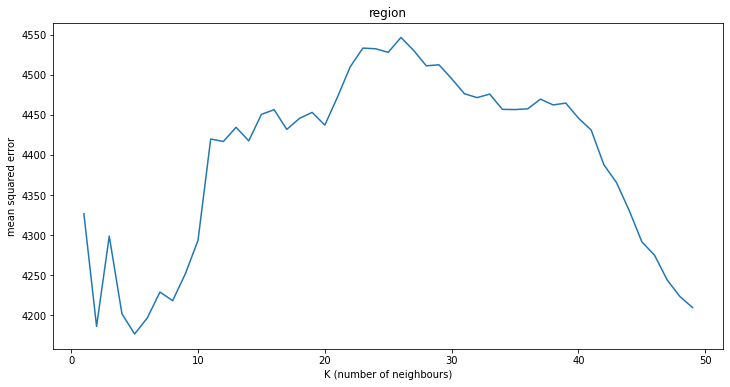

Minimun mean error:  4176.407566666667 at K = 4


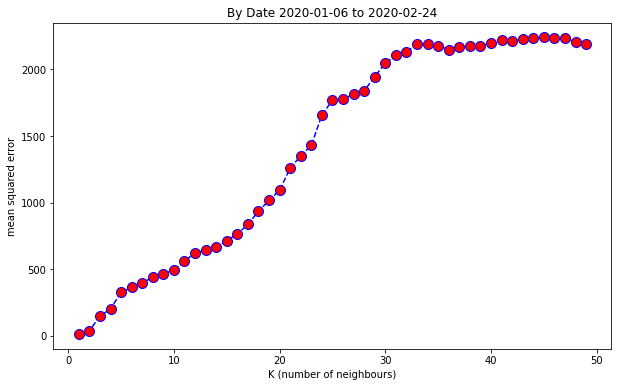

Minimum error:  13.640625 at K = 0


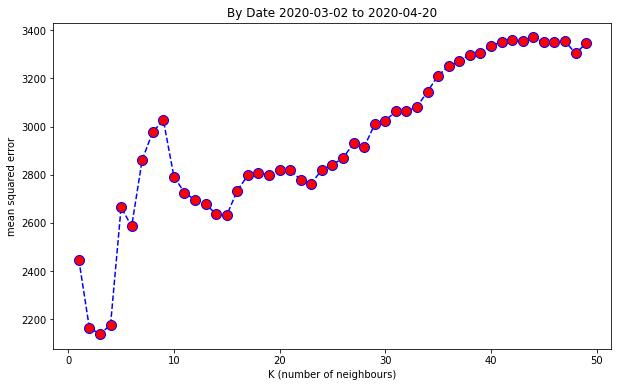

Minimum error:  2138.092013888889 at K = 2


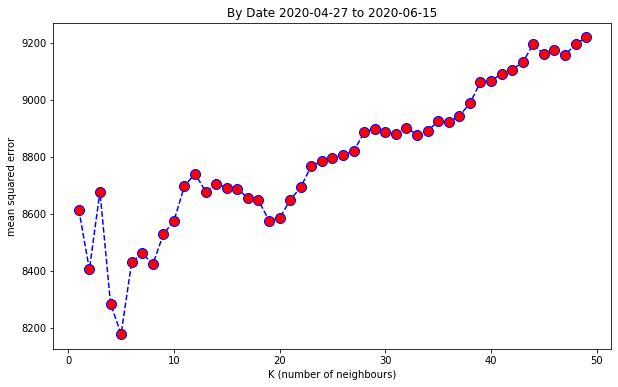

Minimum error:  8177.5953125000015 at K = 4


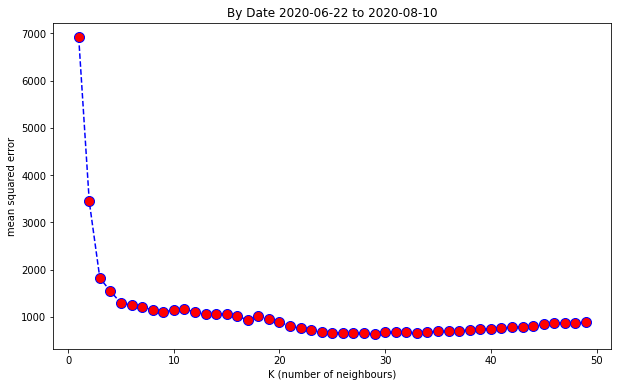

Minimum error:  639.3494073275859 at K = 28


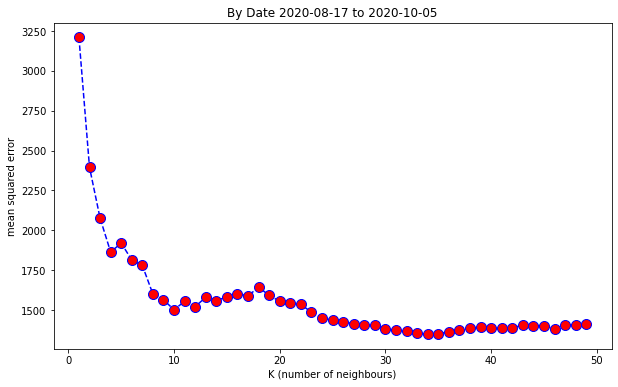

Minimum error:  1349.9874432309691 at K = 33


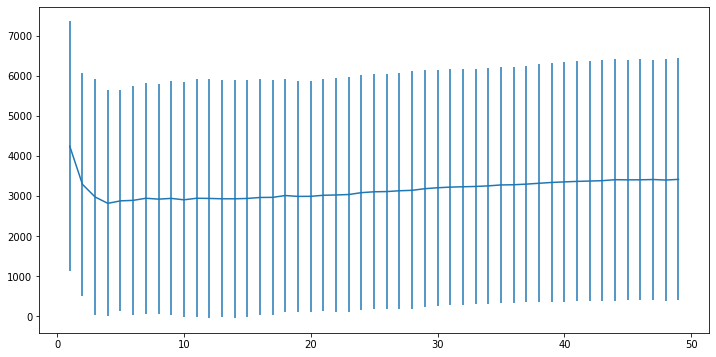

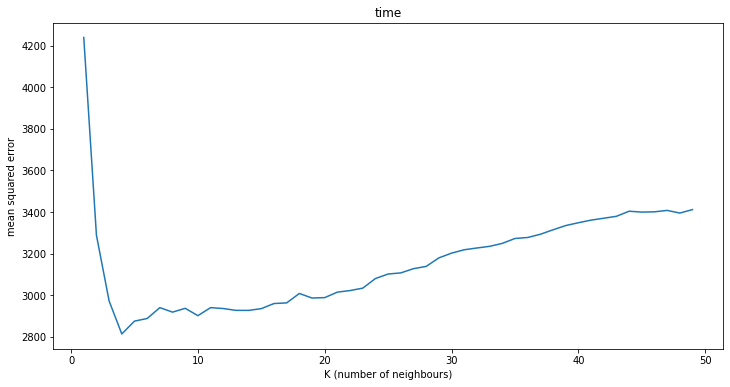

Minimun mean error:  2814.18232421875 at K = 3


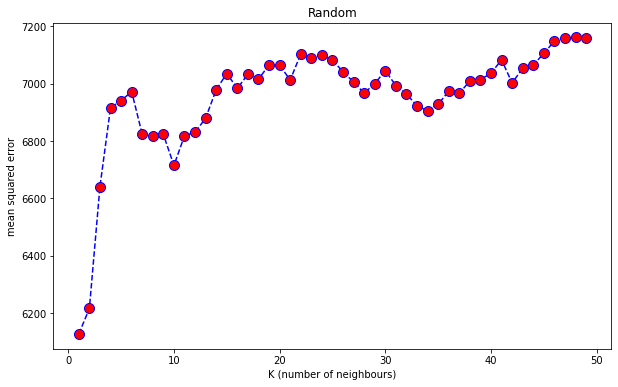

Minimum error:  6127.672 at K = 0


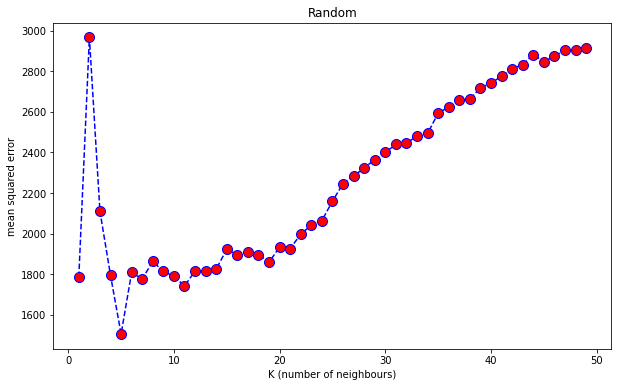

Minimum error:  1505.4134400000003 at K = 4


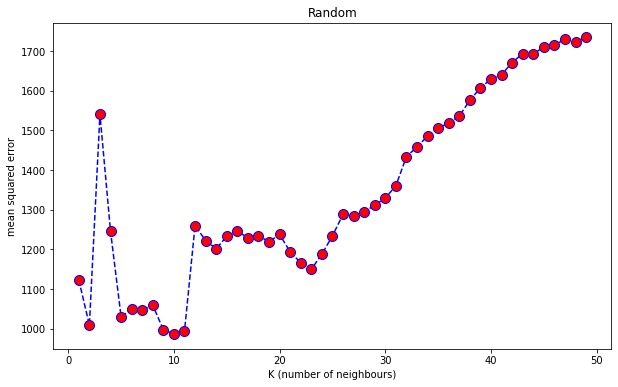

Minimum error:  986.5929599999998 at K = 9


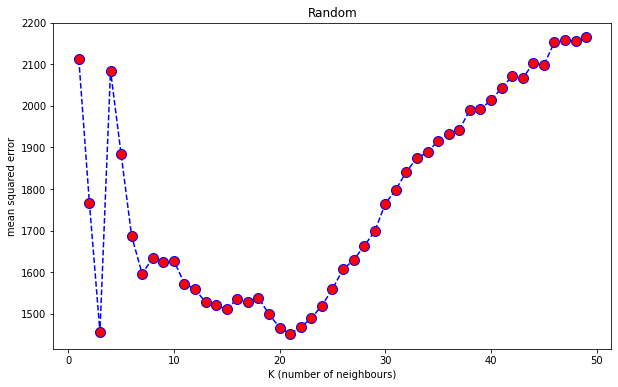

Minimum error:  1451.1676190476192 at K = 20


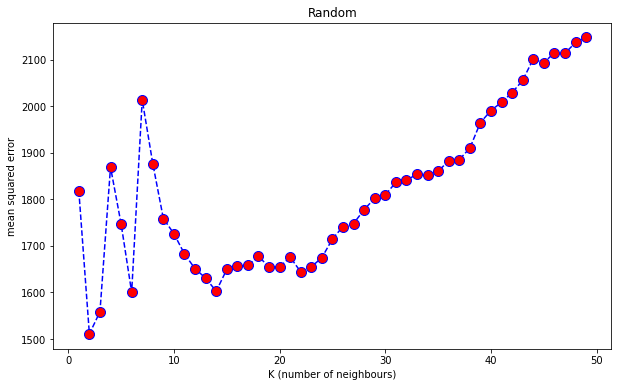

Minimum error:  1510.788306451613 at K = 1


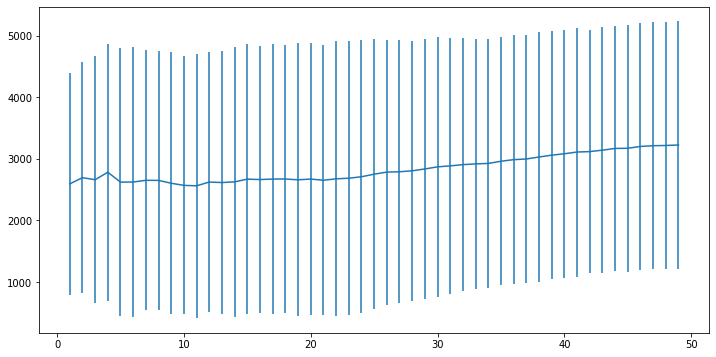

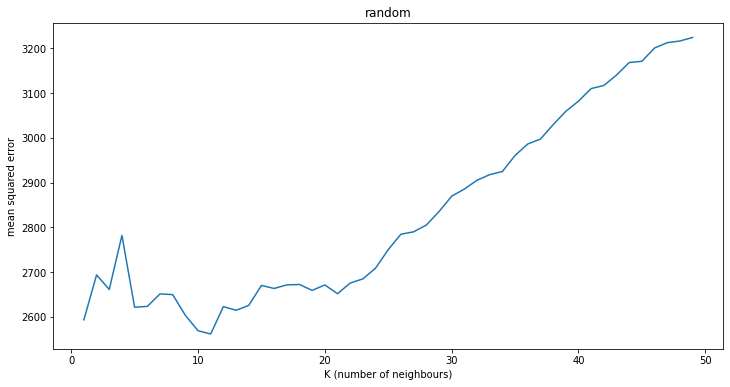

Minimun mean error:  2561.8268039456148 at K = 10


2561.8268039456148

In [23]:
# complete_df will be the margined data 
def knn_Regressor(complete_df, split_type, K_list, num_fold):
  #print("Split Type: " + str(split_type))
  if split_type == 'region':
    splitted = complete_df.open_covid_region_code.unique()
    column = 'open_covid_region_code'
  elif split_type == 'random':
    splitted = np.random.permutation(624)
    column = 'index'
  else:
    splitted = complete_df.date.unique()
    column = 'date'

  splitted = np.array_split(np.array(splitted),num_fold)

  error_cross_valid = np.zeros((len(K_list) , num_fold))
  for s, test_list in enumerate(splitted):

    train = complete_df[~complete_df[column].isin(test_list)]
    test = complete_df[complete_df[column].isin(test_list)]

    X_train = train.drop(train.iloc[:, [0,1,2,4,5,6,7]], axis = 1)
    X_train = X_train.drop(['hospitalized_new'], axis = 1)
    
    X_test = test.drop(test.iloc[:, [0,1,2,4,5,6,7]], axis = 1)
    X_test = X_test.drop(['hospitalized_new'], axis = 1)

    Y_train = train['hospitalized_new']
    Y_test = test['hospitalized_new']


    error_rate = []
    for k, i in enumerate(K_list):
        knn = neighbors.KNeighborsRegressor(n_neighbors=i)
        knn.fit(X_train,Y_train)
        error_rate.append(loss(Y_test, knn.predict(X_test)))
        error_cross_valid[k,s]=loss(Y_test, knn.predict(X_test))

    plt.figure(figsize=(10,6))
    plt.plot(K_list,error_rate,color='blue', linestyle='dashed', 
        marker='o',markerfacecolor='red', markersize=10)

    if split_type == 'region':
        plt.title('By Region')
    if split_type == 'random':
        plt.title('Random')
    else:
        plt.title('By Date ' + str(test_list[0]) +  ' to ' + str(test_list[-1])) 
    plt.xlabel('K (number of neighbours)')
    plt.ylabel('mean squared error')
    plt.show()
    print("Minimum error: ",min(error_rate),"at K =",error_rate.index(min(error_rate)))

  plt.errorbar(K_list, np.mean(error_cross_valid, axis=1), np.std(error_cross_valid, axis=1), label='validation')
  plt.show()
  plt.plot(K_list, np.mean(error_cross_valid, axis=1), label='mean value')
  error_cross_valid_mean = np.mean(error_cross_valid, axis=1).tolist()

  plt.xlabel('K (number of neighbours)')
  plt.ylabel('mean squared error')
  plt.title(split_type)
  plt.show()
  print("Minimun mean error: ", min(np.mean(error_cross_valid, axis=1)), "at K =", error_cross_valid_mean.index(min(np.mean(error_cross_valid, axis=1))))
  return(min(np.mean(error_cross_valid, axis=1)))

merged = pd.read_csv("merged_data.csv")

merged = merged.drop(merged.iloc[:,[0]], axis =1 )
merged_indexed = merged.reset_index()

knn_Regressor(merged_indexed, 'region', range(1,50), 5) 
knn_Regressor(merged_indexed, 'time', range(1,50), 5) 
knn_Regressor(merged_indexed, 'random', range(1,50), 5)

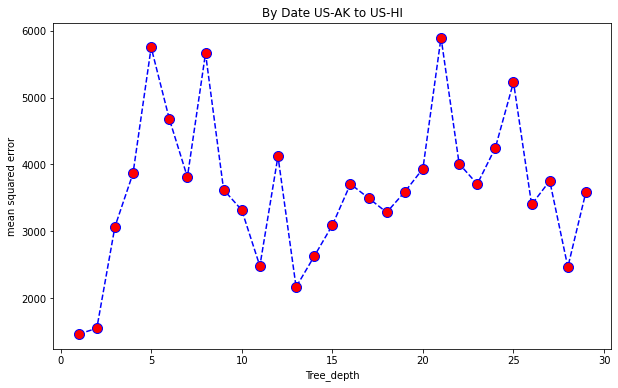

Minimum error:  1462.4473098054737 at depth = 0


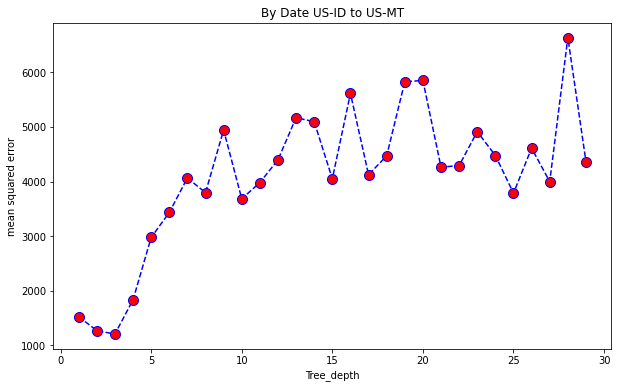

Minimum error:  1207.497556571215 at depth = 2


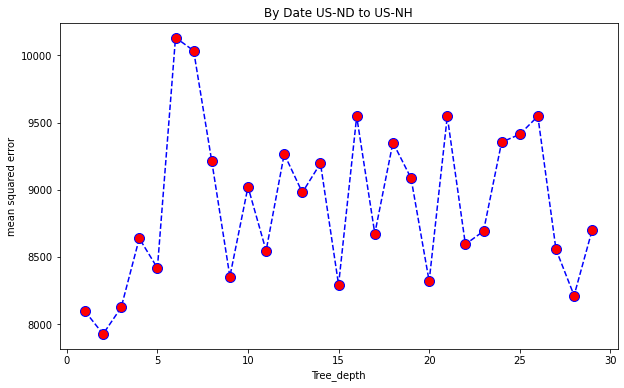

Minimum error:  7926.934646779936 at depth = 1


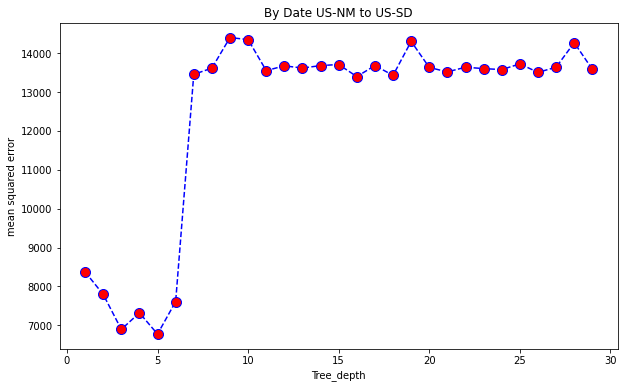

Minimum error:  6772.837119445271 at depth = 4


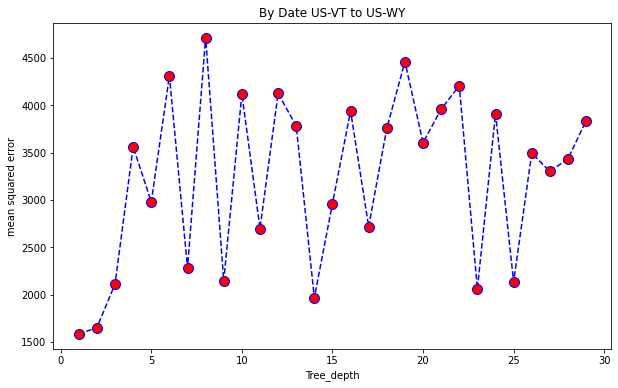

Minimum error:  1582.595394290748 at depth = 0


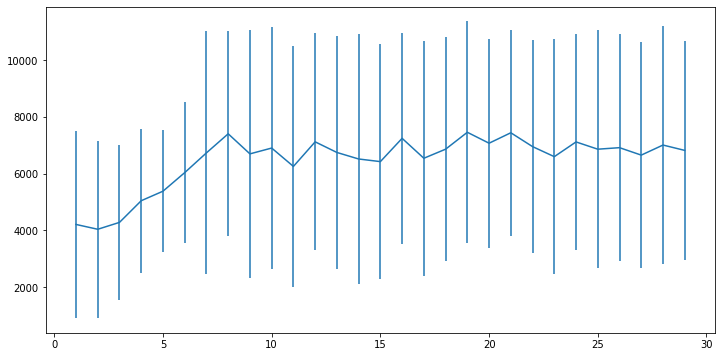

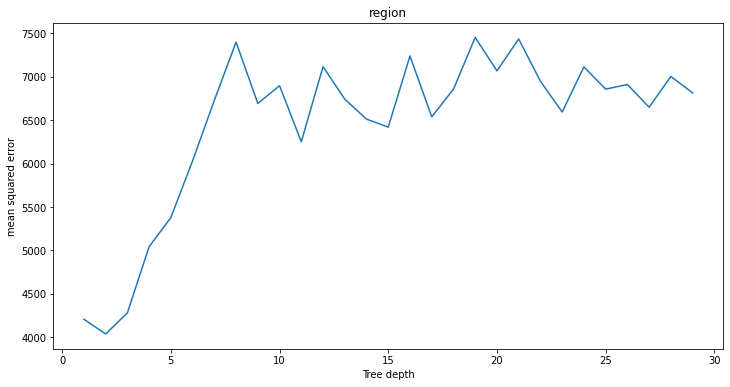

Minimun mean error:  4038.386993211631 at depth = 1


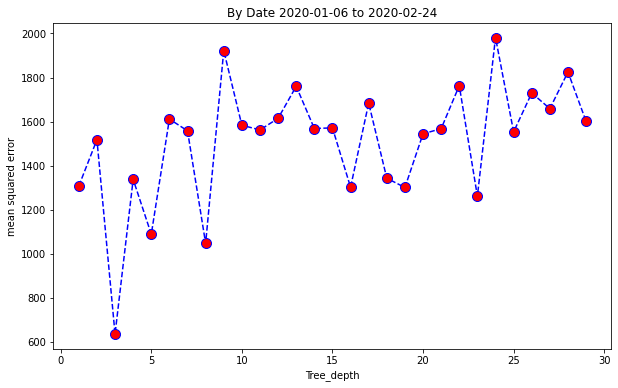

Minimum error:  635.5187027026466 at depth = 2


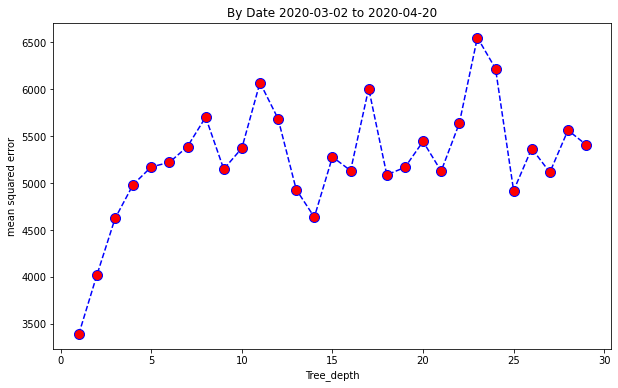

Minimum error:  3391.91249540538 at depth = 0


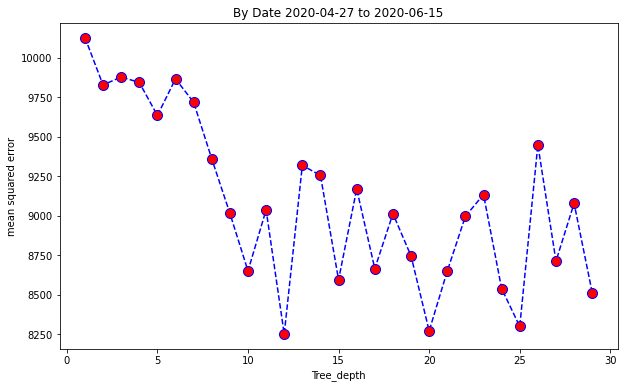

Minimum error:  8250.930689788784 at depth = 11


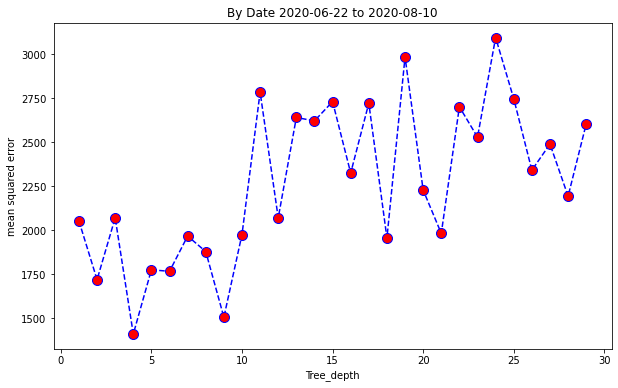

Minimum error:  1409.0983111700375 at depth = 3


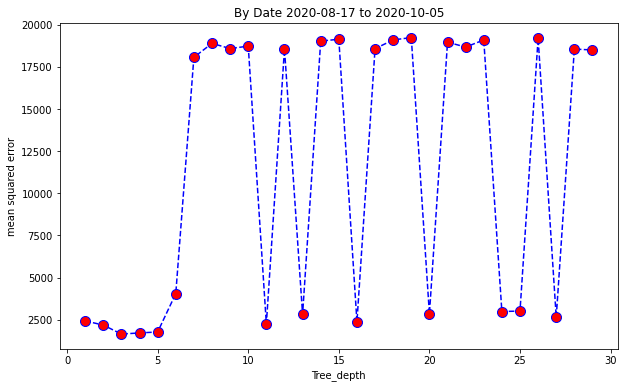

Minimum error:  1647.7112960234601 at depth = 2


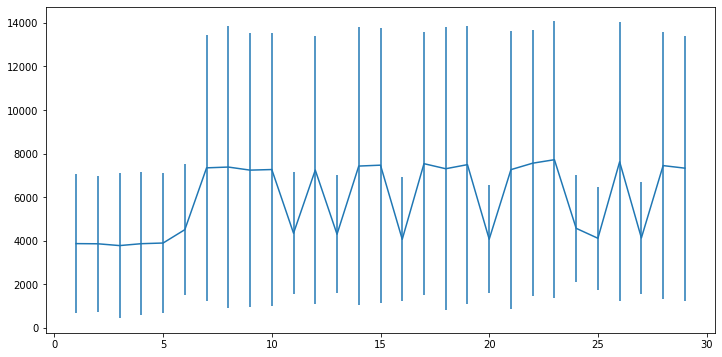

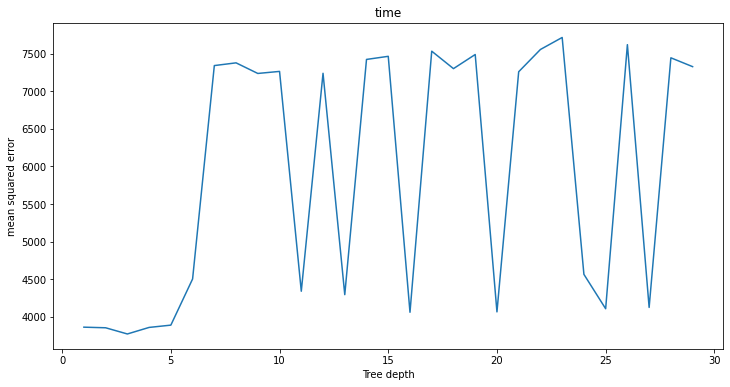

Minimun mean error:  3771.111965787103 at depth = 2


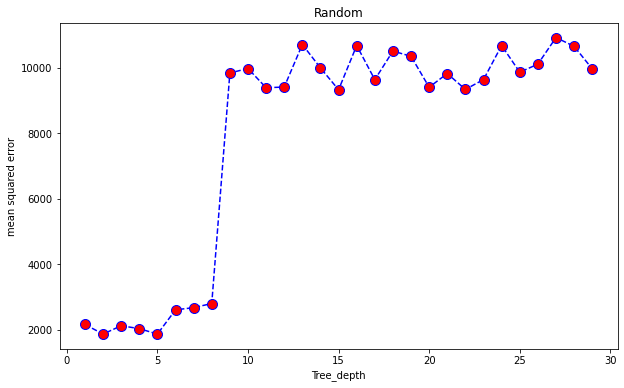

Minimum error:  1862.3706325480237 at depth = 4


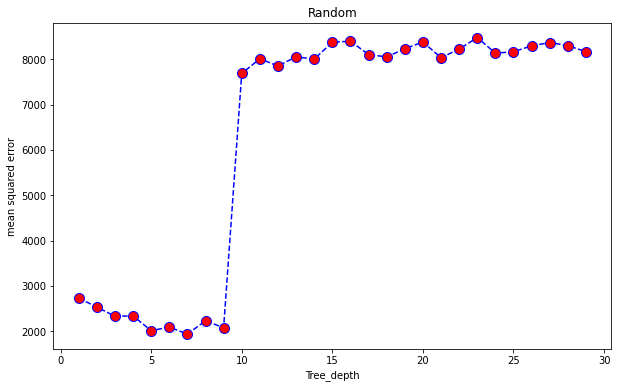

Minimum error:  1938.0584416710572 at depth = 6


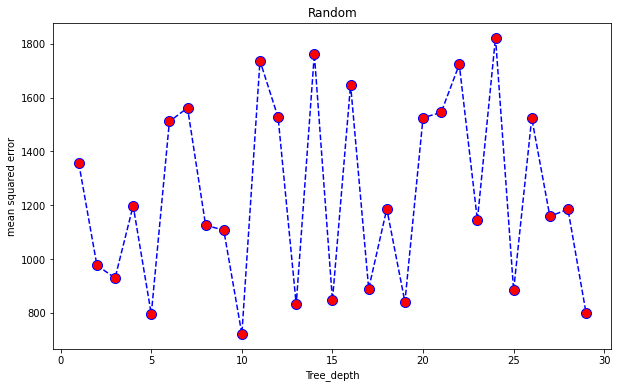

Minimum error:  721.6836133648883 at depth = 9


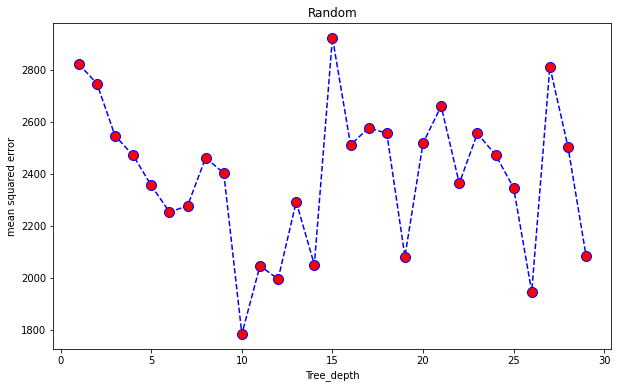

Minimum error:  1783.606477849303 at depth = 9


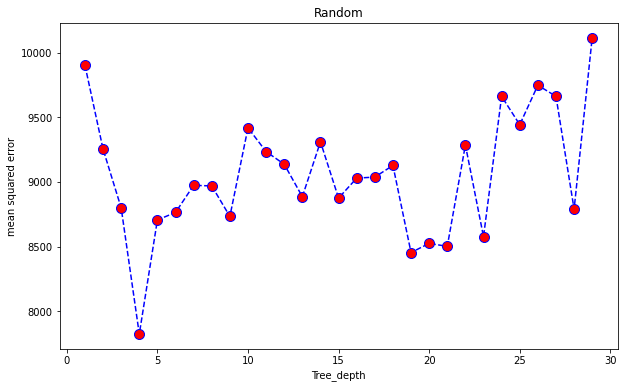

Minimum error:  7822.758602746121 at depth = 3


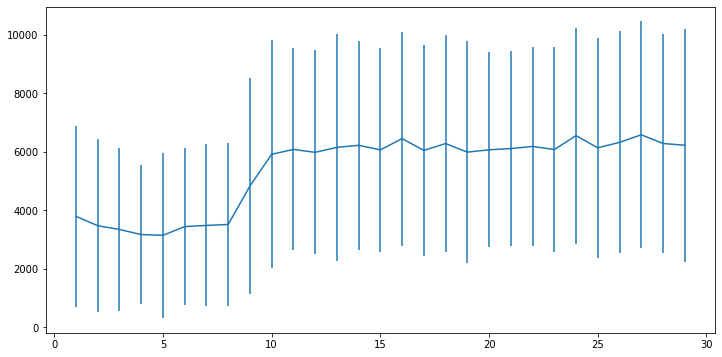

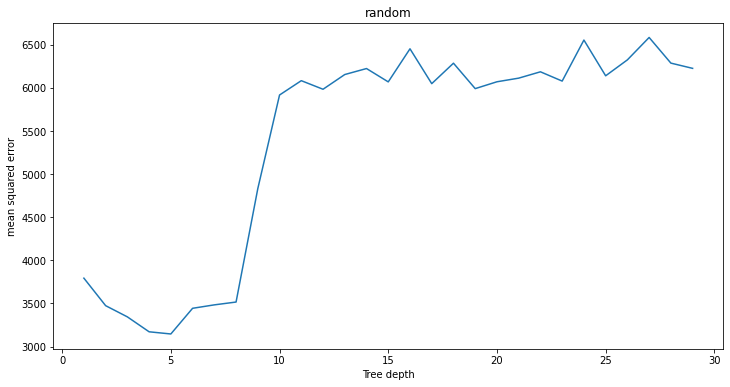

Minimun mean error:  3146.4101361328167 at depth = 4


In [24]:
from sklearn.tree import DecisionTreeRegressor

def Tree_regressor(complete_df, split_type, tree_depth, num_fold):
    #print("Split Type: " + str(split_type))
    if split_type == 'region':
        splitted = complete_df.open_covid_region_code.unique()
        column = 'open_covid_region_code'
    elif split_type == 'random':
        splitted = np.random.permutation(624)
        column = 'index'
    else:
        splitted = complete_df.date.unique()
        column = 'date'

    splitted = np.array_split(np.array(splitted),num_fold)
    #print(splitted)
  
    error_cross_valid = np.zeros((len(tree_depth) , num_fold))
    for s, test_list in enumerate(splitted):

        # column 0-155 in test. column 156-623 remain in train.
        # trian excludes test_list
        # test includes test_list
        train = complete_df[~complete_df[column].isin(test_list)]
        test = complete_df[complete_df[column].isin(test_list)]
        train = train.sample(frac=1)
        test = test.sample(frac=1)

        X_train = train.drop(train.iloc[:, [0,1,2,4,5,6,7]], axis = 1)
        X_train = X_train.drop(['hospitalized_new'], axis = 1)

        X_test = test.drop(test.iloc[:, [0,1,2,4,5,6,7]], axis = 1)
        X_test = X_test.drop(['hospitalized_new'], axis = 1)

        Y_train = train['hospitalized_new']
        Y_test = test['hospitalized_new']

    
        error_rate = []
        for k, i in enumerate(tree_depth):
            dt = DecisionTreeRegressor(max_depth = i)
            dt.fit(X_train,Y_train)
            error_rate.append(loss(Y_test, dt.predict(X_test)))
            error_cross_valid[k,s]=loss(Y_test, dt.predict(X_test))

        plt.figure(figsize=(10,6))
        plt.plot(tree_depth, error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)

        if split_type == 'region':
            plt.title('By Region')
        if split_type == 'random':
            plt.title('Random')
        else:
            plt.title('By Date ' + str(test_list[0]) +  ' to ' + str(test_list[-1])) 
        plt.xlabel('Tree_depth')
        plt.ylabel('mean squared error')
        plt.show()
        print("Minimum error: ",min(error_rate),"at depth =",error_rate.index(min(error_rate)))

    plt.errorbar(tree_depth, np.mean(error_cross_valid, axis=1), np.std(error_cross_valid, axis=1), label='validation')
    plt.show()
    plt.plot(tree_depth, np.mean(error_cross_valid, axis=1), label='mean value')
    error_cross_valid_mean = np.mean(error_cross_valid, axis=1).tolist()
    
    plt.xlabel('Tree depth')
    plt.ylabel('mean squared error')
    plt.title(split_type)
    plt.show()
    print("Minimun mean error: ", min(np.mean(error_cross_valid, axis=1)), "at depth =", error_cross_valid_mean.index(min(np.mean(error_cross_valid, axis=1))))

merged_indexed = merged.reset_index()
Tree_regressor(merged_indexed, 'region', range(1,30), 5)
Tree_regressor(merged_indexed, 'time', range(1,30), 5)
Tree_regressor(merged_indexed, 'random', range(1,30), 5)